In [1]:
import os
import random
import librosa
from tqdm import tqdm
from pydub import AudioSegment
from pydub.generators import WhiteNoise
import numpy as np
import soundfile as sf
import librosa.display
import matplotlib.pyplot as plt

c:\users\ysiberia\documents\github\audiio_classification\venv\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
def split_audo(audio:str,audio_folder:str,sample_length:int,sample_count:int,noise_volume:int):
    '''
    Данная функция генерирует из одного большого аудио файла много файлов поменьше, 
    из которых будет составляться датасет. Все сгенерированные аудио попадают в отдельную директорию, 
    имеющую название исходного файла. 
    
    ==Input==
    audio - путь к исходному файлу
    audio_folder - директория в котороую будет осуществляться генерация
    sample_length - длина генерируемого примера в секундах
    sample_count - количество примеров
    '''
    # проверяем/создаем директорию audio_folder/filename/
    if not os.path.exists(audio_folder):
        os.makedirs(audio_folder)
    sub_folder = os.path.basename(audio).split('.')[0]
    sample_folder = os.path.join(audio_folder,sub_folder)
    if not os.path.exists(sample_folder):
        os.makedirs(sample_folder)

    Audio = AudioSegment.from_wav(audio) # считываем аудио
    bitrate = str((Audio.frame_rate * Audio.frame_width * 8 * Audio.channels) / 1000)
    max = int(Audio.duration_seconds - sample_length - 1) # получаем длину аудио
    for i in range(0,sample_count): # с
        start = random.randint(0, max)
        end = start + sample_length
        sample = Audio[start*1000:end*1000]
        #print(abs(sample.dBFS))
        dbfs=round(abs(sample.dBFS)*(random.randint(0,noise_volume)/100),1)
        #print(dbfs)
        volume1=round(sample.dBFS+dbfs)
        noise = WhiteNoise().to_audio_segment(duration=len(sample),volume=volume1)
        sample = sample.overlay(noise)
        sample_name = sub_folder+f'_{i}_.wav'
        sample_path=os.path.join(sample_folder,sample_name)
        sample.export(sample_path, format="wav",bitrate=bitrate)

In [3]:
def split_all_audio(audio_path:str,audio_folder:str,sample_length:int,sample_count:int,noise_volume:int):
    '''
    Данная функция в цикле применит функцию split_audo к каждому файлу в директории с расширением wav
    ==Input==
    audio_path - директория с исходными файлами
    audio_folder - директория в котороую будет осуществляться генерация
    sample_length - длина генерируемого примера в секундах
    sample_count - количество примеров
    
    '''
    for subdir, dirs, files in os.walk(audio_path):
            print(subdir)
            for file in tqdm(files):
                filepath = subdir + os.sep + file
                if filepath.endswith(".wav"):
                    split_audo(filepath,audio_folder,sample_length,sample_count,noise_volume)

In [5]:
split_all_audio(r'noise_data',r'split10_noise',10,400,20)

C:\Users\Ysiberia\Documents\GitHub\audiio_classification\original_data


100%|███████████████████████████████████████████████████████████████████████████████| 9/9 [07:54<00:00, 52.72s/it]


In [5]:
import os
import random
import librosa
from tqdm import tqdm
from pydub import AudioSegment
import numpy as np
import soundfile as sf
import librosa.display
import matplotlib.pyplot as plt

In [6]:
def _plot_signal_and_augmented_signal(signal, augmented_signal, sr):
    fig, ax = plt.subplots(nrows=2,figsize=(15,15))
    librosa.display.waveshow(signal, sr=sr, ax=ax[0])
    ax[0].set(title="Original signal")
    librosa.display.waveshow(augmented_signal, sr=sr, ax=ax[1])
    ax[1].set(title="Augmented signal")
    plt.show()

In [7]:
def add_white_noise(signal, noise_percentage_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal

In [8]:
def time_stretch(signal, time_stretch_rate):
    return librosa.effects.time_stretch(signal, time_stretch_rate)

In [9]:
def pitch_scale(signal, sr, num_semitones):
    return librosa.effects.pitch_shift(signal, sr, num_semitones)

In [10]:
def random_gain(signal, min_factor=0.5, max_factor=2):
    gain_rate = random.uniform(min_factor, max_factor)
    augmented_signal = signal * gain_rate
    return augmented_signal

In [11]:
def invert_polarity(signal):
    return signal * -1

дальше примеры аугментации и сразу график. у меня при обучении только белый шум применялся. лучше на коротки аудио чтоб были видны изменения на текущем масштабе.

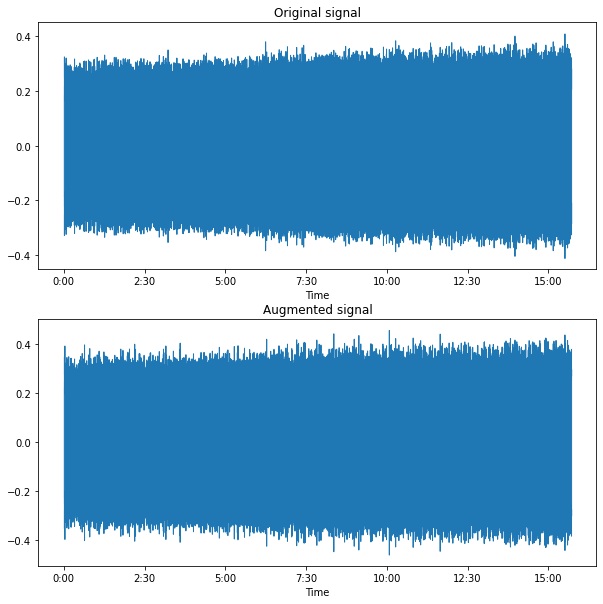

In [11]:
signal, sr = librosa.load(r"original_data/Test1.wav")
augmented_signal = add_white_noise(signal,0.5) # добавление белого шума. уровень шума - второй аргумент
#augmented_signal = time_stretch(signal, 0.8) # изменение скорости воспроизведения
#augmented_signal = pitch_scale(signal, sr, 6) # изменение тональнрсим
#augmented_signal = random_gain(signal) # уменьшение-увеличение амплитуды
#augmented_signal = invert_polarity(signal) # инверсия

sf.write("augmented_audio.wav", augmented_signal, sr)
_plot_signal_and_augmented_signal(signal, augmented_signal, sr)

In [12]:
def augmentation(signal,min_noise_percentage_factor = 0.1,
                 max_noise_percentage_factor = 0.5,
                 min_factor=0.5, 
                 max_factor=1.5):
    noise_percentage_factor = random.uniform(min_noise_percentage_factor, max_noise_percentage_factor)
    augmented_signal = add_white_noise(signal, noise_percentage_factor)
    augmented_signal = random_gain(augmented_signal,min_factor=0.5, max_factor=2)
    
    return augmented_signal

In [13]:
def split_audo_with_augmentation(audio:str,
                                 audio_folder:str,
                                 sample_length:int,
                                 sample_count:int,
                                 min_noise_percentage_factor = 0.0,
                                 max_noise_percentage_factor = 0.8,
                                 min_factor=0.5, 
                                 max_factor=2):
    '''
    Данная функция генерирует из одного большого аудио файла много файлов поменьше, 
    из которых будет составляться датасет. Все сгенерированные аудио попадают в отдельную директорию, 
    имеющую название исходного файла. 
    
    ==Input==
    audio - путь к исходному файлу
    audio_folder - директория в котороую будет осуществляться генерация
    sample_length - длина генерируемого примера в секундах
    sample_count - количество примеров
    '''
    # проверяем/создаем директорию audio_folder/filename/
    if not os.path.exists(audio_folder):
        os.makedirs(audio_folder)
    sub_folder = os.path.basename(audio).split('.')[0]
    sample_folder = os.path.join(audio_folder,sub_folder)
    if not os.path.exists(sample_folder):
        os.makedirs(sample_folder)

    signal, sr = librosa.load(audio) # считываем ауди

    length = librosa.get_duration(y=signal, sr=sr)

    max = int(length - sample_length -1) # получаем длину аудио
    for i in range(0,sample_count): # с
        start = random.randint(0, max)*sr
        end = start + sample_length*sr
        sound = signal[start:end]
        
        noise_percentage_factor = random.uniform(min_noise_percentage_factor, 
                                                 max_noise_percentage_factor)
        
        gain_rate = random.uniform(min_factor, max_factor)
        sound = add_white_noise(sound,noise_percentage_factor)
        #sound = random_gain(sound,gain_rate)
        sample_name = sub_folder+f'_{i}_.wav'
        sample_path=os.path.join(sample_folder,sample_name)

        sf.write(sample_path, sound, sr)

        #sample.export(sample_path, format="wav")

In [14]:
def split_all_audio(audio_path:str,audio_folder:str,sample_length:int,sample_count:int):
    '''
    Данная функция в цикле применит функцию split_audo к каждому файлу в директории с расширением wav
    ==Input==
    audio_path - директория с исходными файлами
    audio_folder - директория в котороую будет осуществляться генерация
    sample_length - длина генерируемого примера в секундах
    sample_count - количество примеров
    
    '''
    for subdir, dirs, files in os.walk(audio_path):
            print(subdir)
            for file in tqdm(files):
                filepath = subdir + os.sep + file
                if filepath.endswith(".wav"):
                    print(filepath)
                    split_audo_with_augmentation(filepath,audio_folder,sample_length,sample_count)

In [15]:
split_all_audio(r'C:\Users\Ysiberia\Documents\GitHub\audiio_classification\original_data',r'split10_noise',10,10)

C:\Users\Ysiberia\Documents\GitHub\audiio_classification\original_data


  0%|                                                                                      | 0/13 [00:00<?, ?it/s]

C:\Users\Ysiberia\Documents\GitHub\audiio_classification\original_data\Test1.wav


  8%|█████▉                                                                       | 1/13 [02:02<24:32, 122.69s/it]

C:\Users\Ysiberia\Documents\GitHub\audiio_classification\original_data\Test10.wav


 15%|████████████                                                                  | 2/13 [02:10<10:09, 55.40s/it]

C:\Users\Ysiberia\Documents\GitHub\audiio_classification\original_data\Test11.wav


 23%|██████████████████                                                            | 3/13 [02:35<06:50, 41.09s/it]

C:\Users\Ysiberia\Documents\GitHub\audiio_classification\original_data\Test12.wav


 31%|████████████████████████                                                      | 4/13 [03:01<05:19, 35.46s/it]

C:\Users\Ysiberia\Documents\GitHub\audiio_classification\original_data\Test13.wav


 38%|██████████████████████████████                                                | 5/13 [03:30<04:23, 32.91s/it]

C:\Users\Ysiberia\Documents\GitHub\audiio_classification\original_data\Test2.wav


 46%|████████████████████████████████████                                          | 6/13 [03:55<03:30, 30.13s/it]

C:\Users\Ysiberia\Documents\GitHub\audiio_classification\original_data\Test3.wav


 54%|██████████████████████████████████████████                                    | 7/13 [04:19<02:49, 28.18s/it]

C:\Users\Ysiberia\Documents\GitHub\audiio_classification\original_data\Test4.wav


 62%|████████████████████████████████████████████████                              | 8/13 [04:43<02:14, 27.00s/it]

C:\Users\Ysiberia\Documents\GitHub\audiio_classification\original_data\Test5.wav


 69%|██████████████████████████████████████████████████████                        | 9/13 [05:06<01:43, 25.85s/it]

C:\Users\Ysiberia\Documents\GitHub\audiio_classification\original_data\Test6.wav


 77%|███████████████████████████████████████████████████████████▏                 | 10/13 [05:22<01:08, 22.72s/it]

C:\Users\Ysiberia\Documents\GitHub\audiio_classification\original_data\Test7.wav


 85%|█████████████████████████████████████████████████████████████████▏           | 11/13 [05:46<00:45, 22.94s/it]

C:\Users\Ysiberia\Documents\GitHub\audiio_classification\original_data\Test9.wav


100%|█████████████████████████████████████████████████████████████████████████████| 13/13 [05:53<00:00, 27.23s/it]


In [4]:
import os
import random
import numpy as np
from tqdm import tqdm
from pydub import AudioSegment

In [5]:
def split_audo(audio:str,audio_folder:str,sample_length:int,sample_count:int):
    '''
    Данная функция генерирует из одного большого аудио файла много файлов поменьше, 
    из которых будет составляться датасет. Все сгенерированные аудио попадают в отдельную директорию, 
    имеющую название исходного файла. 
    
    ==Input==
    audio - путь к исходному файлу
    audio_folder - директория в котороую будет осуществляться генерация
    sample_length - длина генерируемого примера в секундах
    sample_count - количество примеров
    '''
    # проверяем/создаем директорию audio_folder/filename/
    if not os.path.exists(audio_folder):
        os.makedirs(audio_folder)
    sub_folder = os.path.basename(audio).split('.')[0]
    sample_folder = os.path.join(audio_folder,sub_folder)
    if not os.path.exists(sample_folder):
        os.makedirs(sample_folder)
        
    print(audio)

    Audio = AudioSegment.from_wav(audio) # считываем аудио
    max = int(Audio.duration_seconds - sample_length - 1) # получаем длину аудио
    for i in range(0,sample_count): # с
        start = random.randint(0, max)
        end = start + sample_length
        sample = Audio[start*1000:end*1000]
        sample_name = sub_folder+f'_{i}_.wav'
        sample_path=os.path.join(sample_folder,sample_name)
        sample.export(sample_path, format="wav")

In [6]:
def split_all_audio(audio_path:str,audio_folder:str,sample_length:int,sample_count:int):
    '''
    Данная функция в цикле применит функцию split_audo к каждому файлу в директории с расширением wav
    ==Input==
    audio_path - директория с исходными файлами
    audio_folder - директория в котороую будет осуществляться генерация
    sample_length - длина генерируемого примера в секундах
    sample_count - количество примеров
    
    '''
    for subdir, dirs, files in os.walk(audio_path):
            print(subdir)
            for file in tqdm(files):
                filepath = subdir + os.sep + file
                if filepath.endswith(".wav"):
                    print(filepath)
                    split_audo(filepath,audio_folder,sample_length,sample_count)

In [7]:
split_all_audio(r'./noise_data',r'./noise_cut_data',10,400)

./noise_data


  0%|                                                                                       | 0/8 [00:00<?, ?it/s]

./noise_data\Test11Noise.wav
./noise_data\Test11Noise.wav


 12%|█████████▉                                                                     | 1/8 [00:03<00:22,  3.23s/it]

./noise_data\Test13Noise.wav
./noise_data\Test13Noise.wav


 25%|███████████████████▊                                                           | 2/8 [00:07<00:22,  3.70s/it]

./noise_data\Test1Noise.wav
./noise_data\Test1Noise.wav


 38%|█████████████████████████████▋                                                 | 3/8 [00:11<00:19,  3.93s/it]

./noise_data\Test3Noise.wav
./noise_data\Test3Noise.wav


 50%|███████████████████████████████████████▌                                       | 4/8 [00:26<00:33,  8.30s/it]

./noise_data\Test4Noise.wav
./noise_data\Test4Noise.wav


 62%|█████████████████████████████████████████████████▍                             | 5/8 [00:47<00:38, 12.99s/it]

./noise_data\Test5Noise.wav
./noise_data\Test5Noise.wav


 75%|███████████████████████████████████████████████████████████▎                   | 6/8 [01:07<00:30, 15.31s/it]

./noise_data\Test6Noise.wav
./noise_data\Test6Noise.wav


 88%|█████████████████████████████████████████████████████████████████████▏         | 7/8 [01:32<00:18, 18.41s/it]

./noise_data\Test7Noise.wav
./noise_data\Test7Noise.wav


100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [02:03<00:00, 15.40s/it]


In [ ]:
split_all_audio('./original_data','./splited_data_10',10,70)